In [7]:
# import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# load hourly dataset
bikes_df = pd.read_csv('bike_sharing_dataset/hour.csv')

In [5]:
# explore
bikes_df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


#### feature information   

* instant: record index 
* dteday: datetime 
* season of the year (1: spring, 2: summer, 3: fall, 4: winter)
* yr: (0:2011, 1: 2012) 
* mnth: month(1 to 12)
* hr: hour (0 to 23) 
* holiday: (1 is holiday, 0 is not) 
* weekday: day of the week 
* working day: neither holiday or weekend is 1 otherwise 0
* weathersit : 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

In [6]:
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### data type summary:

* zero non null objects 
* dteday: convert to datetime object
* convert season, yr, mnth, holiday, weekday, workingday, weathersit to categorical value 

In [12]:
# don't need instant column 
bikes_df.drop(columns=['instant'], inplace=True)
bikes_df.head(2)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [14]:
bikes_df['dteday'] = pd.to_datetime(bikes_df.dteday)

In [18]:
# hour will convert to string and change into categorical
bikes_df['hr'] = bikes_df.hr.astype('str').astype('category')

In [30]:
def change_colvalue(df, colname, colvaluemap):
    '''
    inputs: 
    df: a pandas dataframe with the colnames needed to be changed 
    colname: the colname for df needed to be changed 
    colnamemap: a dictionary with original colvalue as key and
                desired colvalue as value 
    returns:
    a list with the desired colvalue
    '''
    changed_name = df[colname].map(colvaluemap)
    return changed_name

In [31]:
# convert numerical columns to categorical columns 
# columns of interest 
cat_cols = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
col_dict_maps = [{1:'spring',2:'summer',3:'fall',4:'winter'},
                {0:'2011', 1: '2012'}, 
                {1:'jan', 2:'feb',3:'mar',4:'apr',5:'may', 6:'jun',7:'jul',8:'aug',
                 9:'sep',10:'oct',11:'nov',12:'dec'}, {1:'holiday',0:'not_holiday'},
                {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'},
                {1:'working',0:'not_working'},
                {1:'clear',2:'mist',3:'light_rain_snow',4:'heavy_rain_snow'}]
for col, dict_map in zip(cat_cols,col_dict_maps):
    bikes_df[col] = change_colvalue(bikes_df,col, dict_map)

    

In [35]:
# convert them to categorical value
bikes_df[cat_cols] = bikes_df[cat_cols].astype('category')

In [40]:
# one hot encoder 
bikes_df = pd.get_dummies(bikes_df)

In [42]:
bikes_df.columns

Index(['dteday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'yr_2011', 'yr_2012', 'mnth_apr', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov',
       'mnth_oct', 'mnth_sep', 'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
       'hr_7', 'hr_8', 'hr_9', 'holiday_holiday', 'holiday_not_holiday',
       'weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'workingday_not_working',
       'workingday_working', 'weathersit_clear', 'weathersit_heavy_rain_snow',
       'weathersit_light_rain_snow', 'weathersit_mist'],
      dtype='object')

In [52]:
# remove the last category for each categorical values
columns_dropped = ['season_winter', 'yr_2011', 'mnth_dec', 'hr_23','holiday_not_holiday','weekday_Sun', 'workingday_not_working', 'weathersit_clear']
bikes_df = bikes_df.drop(columns = columns_dropped)

In [54]:
bikes_df[['temp','atemp','casual','registered','cnt']].corr()
# we will pick temp as highly correlated 

,temp,atemp,casual,registered,cnt
temp,1.000000,0.987672,0.459616,0.335361,0.404772
atemp,0.987672,1.000000,0.454080,0.332559,0.400929
casual,0.459616,0.454080,1.000000,0.506618,0.694564
registered,0.335361,0.332559,0.506618,1.000000,0.972151
cnt,0.404772,0.400929,0.694564,0.972151,1.000000


In [56]:
bikes_df.drop(columns=['atemp'], inplace = True)

In [59]:
# set dteday as index 
bikes_df.set_index('dteday',inplace=True)

In [62]:
# look seasonality or month for features 
bikes_df[['casual', 'registered', 'cnt',
       'season_fall', 'season_spring', 'season_summer']].corr()

,casual,registered,cnt,season_fall,season_spring,season_summer
casual,1.000000,0.506618,0.694564,0.175067,-0.246476,0.123983
registered,0.506618,1.000000,0.972151,0.124675,-0.213866,0.032345
cnt,0.694564,0.972151,1.000000,0.151621,-0.245456,0.060692
season_fall,0.175067,0.124675,0.151621,1.000000,-0.335693,-0.344433
season_spring,-0.246476,-0.213866,-0.245456,-0.335693,1.000000,-0.331312
season_summer,0.123983,0.032345,0.060692,-0.344433,-0.331312,1.000000


In [65]:
bikes_df[['casual', 'registered', 'cnt','mnth_apr','mnth_aug', 'mnth_feb', 
          'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar','mnth_may', 'mnth_nov', 
          'mnth_oct', 'mnth_sep',]].corr()

,casual,registered,cnt,mnth_apr,mnth_aug,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep
casual,1.000000,0.506618,0.694564,0.040407,0.081310,-0.143796,-0.165430,0.104571,0.095392,-0.033971,0.092592,-0.062139,0.033726,0.080753
registered,0.506618,1.000000,0.972151,-0.017531,0.071371,-0.099499,-0.134061,0.051572,0.070311,-0.057400,0.037455,-0.003815,0.054214,0.075476
cnt,0.694564,0.972151,1.000000,-0.003645,0.081657,-0.122113,-0.156834,0.071459,0.084600,-0.057131,0.056422,-0.020074,0.054406,0.084931
mnth_apr,0.040407,-0.017531,-0.003645,1.000000,-0.091432,-0.086815,-0.089865,-0.091872,-0.090242,-0.091365,-0.091872,-0.090139,-0.090617,-0.090139
mnth_aug,0.081310,0.071371,0.081657,-0.091432,1.000000,-0.088061,-0.091155,-0.093190,-0.091536,-0.092675,-0.093190,-0.091432,-0.091917,-0.091432
mnth_feb,-0.143796,-0.099499,-0.122113,-0.086815,-0.088061,1.000000,-0.086552,-0.088484,-0.086914,-0.087995,-0.088484,-0.086815,-0.087276,-0.086815
mnth_jan,-0.165430,-0.134061,-0.156834,-0.089865,-0.091155,-0.086552,1.000000,-0.091593,-0.089968,-0.091087,-0.091593,-0.089865,-0.090342,-0.089865
mnth_jul,0.104571,0.051572,0.071459,-0.091872,-0.093190,-0.088484,-0.091593,1.000000,-0.091976,-0.093121,-0.093638,-0.091872,-0.092359,-0.091872
mnth_jun,0.095392,0.070311,0.084600,-0.090242,-0.091536,-0.086914,-0.089968,-0.091976,1.000000,-0.091469,-0.091976,-0.090242,-0.090720,-0.090242
mnth_mar,-0.033971,-0.057400,-0.057131,-0.091365,-0.092675,-0.087995,-0.091087,-0.093121,-0.091469,1.000000,-0.093121,-0.091365,-0.091849,-0.091365


In [67]:
# choose seasonality or month as higher correlation and less cols
bikes_df.drop(columns=['mnth_apr','mnth_aug', 'mnth_feb', 
          'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar','mnth_may', 'mnth_nov', 
          'mnth_oct', 'mnth_sep'], inplace=True)

In [71]:
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 44 columns):
temp                          17379 non-null float64
hum                           17379 non-null float64
windspeed                     17379 non-null float64
casual                        17379 non-null int64
registered                    17379 non-null int64
cnt                           17379 non-null int64
season_fall                   17379 non-null uint8
season_spring                 17379 non-null uint8
season_summer                 17379 non-null uint8
yr_2012                       17379 non-null uint8
hr_0                          17379 non-null uint8
hr_1                          17379 non-null uint8
hr_10                         17379 non-null uint8
hr_11                         17379 non-null uint8
hr_12                         17379 non-null uint8
hr_13                         17379 non-null uint8
hr_14                         17379 non-null uint8
h

In [72]:
bikes_df.describe()

,temp,hum,windspeed,casual,registered,cnt,season_fall,season_spring,season_summer,yr_2012,...,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Thu,weekday_Tue,weekday_Wed,workingday_working,weathersit_heavy_rain_snow,weathersit_light_rain_snow,weathersit_mist
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.627229,0.190098,35.676218,153.786869,189.463088,0.258703,0.244088,0.253697,0.502561,...,0.143104,0.142643,0.144542,0.142183,0.141147,0.142413,0.682721,0.000173,0.081650,0.261465
std,0.192556,0.192930,0.122340,49.305030,151.357286,181.387599,0.437935,0.429557,0.435139,0.500008,...,0.350189,0.349719,0.351649,0.349248,0.348184,0.349484,0.465431,0.013138,0.273839,0.439445
min,0.020000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340000,0.480000,0.104500,4.000000,34.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.630000,0.194000,17.000000,115.000000,142.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.660000,0.780000,0.253700,48.000000,220.000000,281.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ff80860>,
      dtype=object)

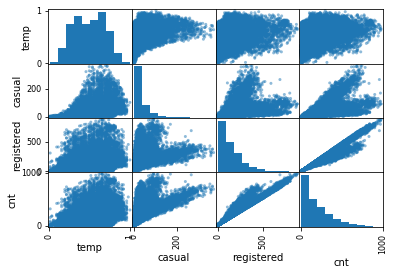

In [80]:
pd.plotting.scatter_matrix(bikes_df[['temp', 'casual','registered','cnt']])
# we will pick temp as highly correlated 

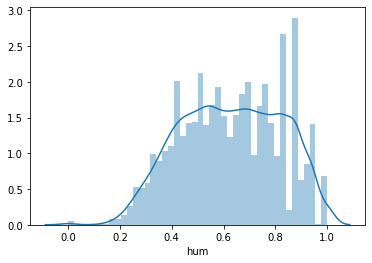

In [94]:
sns.distplot(bikes_df['hum'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13aff3fd0>,
      dtype=object)

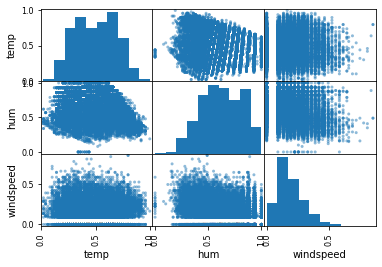

In [98]:
pd.plotting.scatter_matrix(bikes_df[['temp','hum','windspeed']])

In [101]:
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 44 columns):
temp                          17379 non-null float64
hum                           17379 non-null float64
windspeed                     17379 non-null float64
casual                        17379 non-null int64
registered                    17379 non-null int64
cnt                           17379 non-null int64
season_fall                   17379 non-null uint8
season_spring                 17379 non-null uint8
season_summer                 17379 non-null uint8
yr_2012                       17379 non-null uint8
hr_0                          17379 non-null uint8
hr_1                          17379 non-null uint8
hr_10                         17379 non-null uint8
hr_11                         17379 non-null uint8
hr_12                         17379 non-null uint8
hr_13                         17379 non-null uint8
hr_14                         17379 non-null uint8
h